In [1]:
#####################################################
# Demand Forecasting
#####################################################

# Store Item Demand Forecasting Challenge
# https://www.kaggle.com/c/demand-forecasting-kernels-only
!pip install lightgbm

In [2]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
########################
# Loading the data
########################

train = pd.read_csv('C:/Users/cankemaloglu/Desktop/Data Science - Machine Learning Bootcamp 8.Dönem/Haftalık Kodlar ve Sorular/10. Hafta Zaman Serileri/time_series/datasets/demand_forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('C:/Users/cankemaloglu/Desktop/Data Science - Machine Learning Bootcamp 8.Dönem/Haftalık Kodlar ve Sorular/10. Hafta Zaman Serileri/time_series/datasets/demand_forecasting/test.csv', parse_dates=['date'])

sample_sub = pd.read_csv('C:/Users/cankemaloglu/Desktop/Data Science - Machine Learning Bootcamp 8.Dönem/Haftalık Kodlar ve Sorular/10. Hafta Zaman Serileri/time_series/datasets/demand_forecasting/sample_submission.csv')

df = pd.concat([train, test], sort=False)

In [6]:
#####################################################
# EDA
#####################################################

df["date"].min(), df["date"].max()

check_df(df)

df[["store"]].nunique()

df[["item"]].nunique()

df.groupby(["store"])["item"].nunique()

df.groupby(["store", "item"]).agg({"sales": ["sum"]})

df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

df.head()

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [7]:
#####################################################
# FEATURE ENGINEERING
#####################################################

df.head()

def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

df = create_date_features(df)

df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [8]:
########################
# Random Noise
########################

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [9]:
########################
# Lag/Shifted Features
########################

df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

df.groupby(["store", "item"])['sales'].head()

df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

check_df(df)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int64
day_of_month               int64
day_of_year                int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int32
is_month_end               int32
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

In [10]:
########################
# Rolling Mean Features
########################

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})


def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])

In [11]:
########################
# Exponentially Weighted Mean Features
########################

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
check_df(df)

##################### Shape #####################
(958000, 71)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sale

In [12]:
########################
# One-Hot Encoding
########################

df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])


check_df(df)

##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 146, dtype: object
##################### Head #####################
        date  sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_lag_2

In [13]:
########################
# Converting sales to log(1+sales)
########################

df['sales'] = np.log1p(df["sales"].values)

check_df(df)

##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 146, dtype: object
##################### Head #####################
        date     sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_la

In [14]:
#####################################################
# Model
#####################################################

########################
# Custom Cost Function
########################

# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [15]:
########################
# Time-Based Validation Sets
########################

train
test

# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

# 2017'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

In [17]:
########################
# LightGBM ile Zaman Serisi Modeli
########################

# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [18]:
# metric mae: l1, absolute loss, mean_absolute_error, regression_l1
# mse: l2, square loss, mean_squared_error, mse, regression_l2, regression
# rmse, root square loss, root_mean_squared_error, l2_root
# mape, MAPE loss, mean_absolute_percentage_error

# num_leaves: bir ağaçtaki maksimum yaprak sayısı
# learning_rate: shrinkage_rate, eta
# feature_fraction: rf'nin random subspace özelliği. her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı.
# max_depth: maksimum derinlik
# num_boost_round: n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım.

# early_stopping_rounds: validasyon setindeki metrik belirli bir early_stopping_rounds'da ilerlemiyorsa yani
# hata düşmüyorsa modellemeyi durdur.
# hem train süresini kısaltır hem de overfit'e engel olur.
# nthread: num_thread, nthread, nthreads, n_jobs

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols,)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077347 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.051406	training's SMAPE: 17.6048	valid_1's l2: 0.0529291	valid_1's SMAPE: 17.4423
[200]	training's l2: 0.0352651	training's SMAPE: 14.5838	valid_1's l2: 0.0369777	valid_1's SMAPE: 14.886
[300]	training's l2: 0.0324751	training's SMAPE: 14.0227	valid_1's l2: 0.0340944	valid_1's SMAPE: 14.4227
[400]	training's l2: 0.0313786	training's SMAPE: 13.8041	valid_1's l2: 0.0332407	valid_1's SMAPE: 14.264
[500]	training's l2: 0.0307167	training's SMAPE: 13.6716	valid_1's l2: 0.0327018	valid_1's SMAPE: 14.1505
[600]	training's l2: 0.0302443	training's SMAPE: 13.5741	valid_1's l2: 0.0322384	valid_1's SMAPE: 14.042
[700]	training's l2: 0.0299151	training's SMAPE: 13.5045	valid_1's l2: 0.0319012	valid_1's SMAPE: 13.9637
[800]	training's l2: 0.0296314	trai

13.83106786394231

                        feature  split       gain
17          sales_roll_mean_546    927  54.204491
13                sales_lag_364   1262  13.309311
16          sales_roll_mean_365    611   9.848920
60   sales_ewm_alpha_05_lag_365    371   4.941801
18   sales_ewm_alpha_095_lag_91     98   2.668920
..                          ...    ...        ...
78                       item_6      0   0.000000
107                     item_35      0   0.000000
111                     item_39      0   0.000000
74                       item_2      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


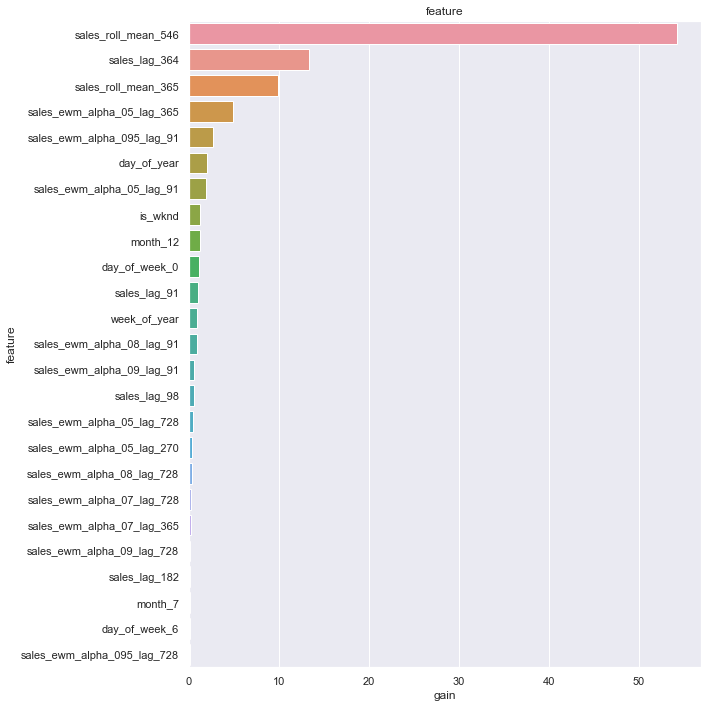

                        feature  split       gain
17          sales_roll_mean_546    927  54.204491
13                sales_lag_364   1262  13.309311
16          sales_roll_mean_365    611   9.848920
60   sales_ewm_alpha_05_lag_365    371   4.941801
18   sales_ewm_alpha_095_lag_91     98   2.668920
..                          ...    ...        ...
78                       item_6      0   0.000000
107                     item_35      0   0.000000
111                     item_39      0   0.000000
74                       item_2      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


110

In [20]:
########################
# Değişken Önem Düzeyleri
########################

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=200)

plot_lgb_importances(model, num=30, plot=True)


feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)


In [21]:
########################
# Final Model
########################

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114574 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [22]:
########################
# Submission File
########################

test.head()

submission_df = test.loc[:, ["id", "sales"]]
submission_df['sales'] = np.expm1(test_preds)

submission_df['id'] = submission_df.id.astype(int)

#submission_df.to_csv("submission_demand.csv", index=False)